# Task 2.6: Final Model Selection - Supervised Learning

---

## Overview

This notebook performs **comprehensive model comparison and selection** for all supervised learning models trained in Week 2. Our goal is to:

1. **Load and compare** all trained supervised models
2. **Evaluate** each model using multiple metrics (Accuracy, F1-Score, Precision, Recall)
3. **Select the top 2 models** with detailed justification
4. **Create a summary comparison table** for easy reference

---

## Why Model Comparison Matters

In machine learning, no single model is universally best. Different models have different strengths:

| Model Type | Strengths | Weaknesses |
|------------|-----------|------------|
| **Logistic Regression** | Interpretable, fast, good baseline | Limited to linear boundaries |
| **Random Forest** | Handles non-linearity, robust to outliers | Can overfit, less interpretable |
| **XGBoost** | State-of-the-art performance, handles imbalance | Complex tuning, slower training |
| **MLP Classifier** | Captures complex patterns, flexible | Requires more data, black-box |

By comparing these models systematically, we can select the best performers for our Airbnb price classification task.

---

## 1. Import Libraries and Load Data

We'll import all necessary libraries for model loading, evaluation, and visualization.

In [1]:
# Standard libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import warnings
warnings.filterwarnings('ignore')

# Sklearn metrics
from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, recall_score,
    classification_report, confusion_matrix, roc_auc_score,
    roc_curve, auc
)
from sklearn.preprocessing import label_binarize

# Set style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')

print('Libraries imported successfully!')

Libraries imported successfully!


## 2. Load Test Data

We load the test dataset that was created during the train-test split in Week 1. This ensures all models are evaluated on the **same unseen data** for fair comparison.

In [2]:
# Load test data
X_test = pd.read_csv('../../data/processed/X_test_scaled.csv')
y_test = pd.read_csv('../../data/processed/y_test.csv')

# Flatten y_test if needed
if isinstance(y_test, pd.DataFrame):
    y_test = y_test.iloc[:, 0].values

print(f'Test set size: {len(X_test)} samples')
print(f'Number of features: {X_test.shape[1]}')
print(f'\nClass distribution in test set:')
print(pd.Series(y_test).value_counts().sort_index())

Test set size: 3983 samples
Number of features: 62

Class distribution in test set:
Excellent_Value    1314
Fair_Value         1355
Poor_Value         1314
Name: count, dtype: int64


## 3. Load All Trained Models

We load all supervised learning models trained in Tasks 2.1-2.5:

- **Task 2.1**: Logistic Regression
- **Task 2.2**: Random Forest
- **Task 2.3**: XGBoost
- **Task 2.5**: MLP Classifier

Each model was saved as a `.pkl` file in the `models/` directory.

In [3]:
# Dictionary to store models
models = {}

# Model file paths - adjust based on your actual file names
model_files = {
    'Logistic Regression': '../../models/logistic_regression_model.pkl',
    'Random Forest': '../../models/random_forest_model.pkl',
    'XGBoost': '../../models/xgboost_model.pkl',
    'MLP Classifier': '../../models/best_mlp_model.pkl',
    'SVM (Linear)': '../../models/svm_linear_model.pkl',
    'SVM (RBF)': '../../models/svm_rbf_model.pkl'
}

# Load each model
for name, path in model_files.items():
    try:
        with open(path, 'rb') as f:
            models[name] = pickle.load(f)
        print(f' {name} loaded successfully')
    except FileNotFoundError:
        print(f' {name} not found at {path}')

print(f'\nTotal models loaded: {len(models)}')

 Logistic Regression loaded successfully
 Random Forest loaded successfully
 XGBoost loaded successfully
 MLP Classifier loaded successfully
 SVM (Linear) loaded successfully
 SVM (RBF) loaded successfully

Total models loaded: 6


## 4. Define Evaluation Function

We create a comprehensive evaluation function that calculates all key metrics for each model:

### Metrics Explained:

| Metric | Description | When to Prioritize |
|--------|-------------|--------------------|
| **Accuracy** | Overall correct predictions / total predictions | Balanced datasets |
| **Precision** | True Positives / (True Positives + False Positives) | When false positives are costly |
| **Recall** | True Positives / (True Positives + False Negatives) | When false negatives are costly |
| **F1-Score** | Harmonic mean of Precision and Recall | Imbalanced datasets |

For our Airbnb price classification (Budget/Mid-Range/Premium), **F1-Score (weighted)** is particularly important as it handles class imbalance well.

In [4]:
def evaluate_model(model, X_test, y_test, model_name):
    """
    Comprehensive model evaluation function.
    
    Parameters:
    -----------
    model : trained sklearn model
    X_test : test features
    y_test : true labels
    model_name : string name of the model
    
    Returns:
    --------
    dict : dictionary containing all evaluation metrics
    """
    # Get predictions
    y_pred = model.predict(X_test)
    
    # Calculate metrics
    metrics = {
        'Model': model_name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'F1-Score (Weighted)': f1_score(y_test, y_pred, average='weighted'),
        'F1-Score (Macro)': f1_score(y_test, y_pred, average='macro'),
        'Precision (Weighted)': precision_score(y_test, y_pred, average='weighted'),
        'Precision (Macro)': precision_score(y_test, y_pred, average='macro'),
        'Recall (Weighted)': recall_score(y_test, y_pred, average='weighted'),
        'Recall (Macro)': recall_score(y_test, y_pred, average='macro')
    }
    
    # Try to get probability predictions for ROC-AUC
    try:
        if hasattr(model, 'predict_proba'):
            y_proba = model.predict_proba(X_test)
            # For multiclass, use OvR approach
            metrics['ROC-AUC (OvR)'] = roc_auc_score(
                y_test, y_proba, multi_class='ovr', average='weighted'
            )
    except:
        metrics['ROC-AUC (OvR)'] = None
    
    return metrics, y_pred

print('Evaluation function defined!')

Evaluation function defined!


## 5. Evaluate All Models

Now we evaluate each loaded model and collect all metrics into a comparison dataframe.

In [5]:
# Mapping for models that output numbers
label_map = {0: 'Excellent_Value', 1: 'Fair_Value', 2: 'Poor_Value'}

def evaluate_model(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)
    
    # Convert numeric predictions to strings if needed
    if isinstance(y_pred[0], (int, np.integer)):
        y_pred = np.array([label_map[p] for p in y_pred])
    
    metrics = {
        'Model': model_name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'F1-Score (Weighted)': f1_score(y_test, y_pred, average='weighted'),
        'F1-Score (Macro)': f1_score(y_test, y_pred, average='macro'),
        'Precision (Weighted)': precision_score(y_test, y_pred, average='weighted'),
        'Precision (Macro)': precision_score(y_test, y_pred, average='macro'),
        'Recall (Weighted)': recall_score(y_test, y_pred, average='weighted'),
        'Recall (Macro)': recall_score(y_test, y_pred, average='macro')
    }
    
    try:
        if hasattr(model, 'predict_proba'):
            y_proba = model.predict_proba(X_test)
            metrics['ROC-AUC (OvR)'] = roc_auc_score(
                y_test, y_proba, multi_class='ovr', average='weighted'
            )
    except:
        metrics['ROC-AUC (OvR)'] = None
    
    return metrics, y_pred

In [6]:
# Store results
all_results = []
predictions = {}

print('='*60)
print('MODEL EVALUATION RESULTS')
print('='*60)

for name, model in models.items():
    print(f'\n--- {name} ---')
    metrics, y_pred = evaluate_model(model, X_test, y_test, name)
    all_results.append(metrics)
    predictions[name] = y_pred
    
    # Print key metrics
    print(f"Accuracy: {metrics['Accuracy']:.4f}")
    print(f"F1-Score (Weighted): {metrics['F1-Score (Weighted)']:.4f}")
    print(f"Precision (Weighted): {metrics['Precision (Weighted)']:.4f}")
    print(f"Recall (Weighted): {metrics['Recall (Weighted)']:.4f}")

# Create comparison dataframe
results_df = pd.DataFrame(all_results)
print('\n' + '='*60)
print('All models evaluated successfully!')

MODEL EVALUATION RESULTS

--- Logistic Regression ---
Accuracy: 0.9902
F1-Score (Weighted): 0.9902
Precision (Weighted): 0.9903
Recall (Weighted): 0.9902

--- Random Forest ---
Accuracy: 0.9709
F1-Score (Weighted): 0.9709
Precision (Weighted): 0.9711
Recall (Weighted): 0.9709

--- XGBoost ---
Accuracy: 0.9940
F1-Score (Weighted): 0.9940
Precision (Weighted): 0.9940
Recall (Weighted): 0.9940

--- MLP Classifier ---
Accuracy: 0.9842
F1-Score (Weighted): 0.9842
Precision (Weighted): 0.9842
Recall (Weighted): 0.9842

--- SVM (Linear) ---
Accuracy: 0.9327
F1-Score (Weighted): 0.9328
Precision (Weighted): 0.9335
Recall (Weighted): 0.9327

--- SVM (RBF) ---
Accuracy: 0.9440
F1-Score (Weighted): 0.9440
Precision (Weighted): 0.9440
Recall (Weighted): 0.9440

All models evaluated successfully!


## 6. Summary Comparison Table

This is the **core deliverable** - a comprehensive comparison table showing all models and their performance metrics side by side.

### Interpretation Guide:
- **Higher is better** for all metrics
- Values range from 0 to 1 (or 0% to 100%)
- **Bold** values indicate the best performer for each metric

In [7]:
# Create formatted comparison table
comparison_table = results_df.set_index('Model')[[
    'Accuracy', 'F1-Score (Weighted)', 'Precision (Weighted)', 'Recall (Weighted)'
]].round(4)

# Sort by F1-Score (our primary metric)
comparison_table = comparison_table.sort_values('F1-Score (Weighted)', ascending=False)

print('\n' + '='*70)
print('SUMMARY COMPARISON TABLE - SUPERVISED LEARNING MODELS')
print('='*70)
print(comparison_table.to_string())
print('='*70)

# Highlight best values
print('\n Best Performers by Metric:')
for col in comparison_table.columns:
    best_model = comparison_table[col].idxmax()
    best_value = comparison_table[col].max()
    print(f'  • {col}: {best_model} ({best_value:.4f})')


SUMMARY COMPARISON TABLE - SUPERVISED LEARNING MODELS
                     Accuracy  F1-Score (Weighted)  Precision (Weighted)  Recall (Weighted)
Model                                                                                      
XGBoost                0.9940               0.9940                0.9940             0.9940
Logistic Regression    0.9902               0.9902                0.9903             0.9902
MLP Classifier         0.9842               0.9842                0.9842             0.9842
Random Forest          0.9709               0.9709                0.9711             0.9709
SVM (RBF)              0.9440               0.9440                0.9440             0.9440
SVM (Linear)           0.9327               0.9328                0.9335             0.9327

 Best Performers by Metric:
  • Accuracy: XGBoost (0.9940)
  • F1-Score (Weighted): XGBoost (0.9940)
  • Precision (Weighted): XGBoost (0.9940)
  • Recall (Weighted): XGBoost (0.9940)


In [8]:
# Save comparison table to CSV
comparison_table.to_csv('../../outputs/model_comparison_summary.csv')
print('\n Comparison table saved to outputs/model_comparison_summary.csv')

# Display styled table
comparison_table


 Comparison table saved to outputs/model_comparison_summary.csv


,Accuracy,F1-Score (Weighted),Precision (Weighted),Recall (Weighted)
Model,,,,
XGBoost,0.9940,0.9940,0.9940,0.9940
Logistic Regression,0.9902,0.9902,0.9903,0.9902
MLP Classifier,0.9842,0.9842,0.9842,0.9842
Random Forest,0.9709,0.9709,0.9711,0.9709
SVM (RBF),0.9440,0.9440,0.9440,0.9440
SVM (Linear),0.9327,0.9328,0.9335,0.9327


## 7. Visual Comparison

Visualizations help us quickly identify patterns and compare model performance.

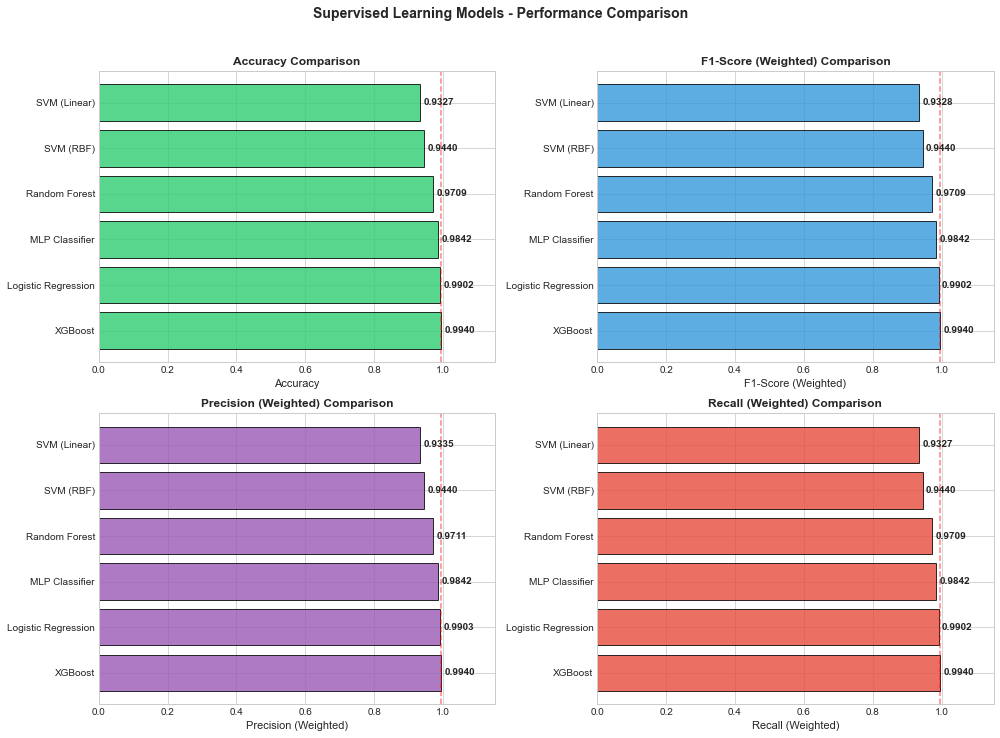


Visualization saved to outputs/figures/model_comparison_metrics.png


In [9]:
# Create comprehensive visualization
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

metrics_to_plot = ['Accuracy', 'F1-Score (Weighted)', 'Precision (Weighted)', 'Recall (Weighted)']
colors = ['#2ecc71', '#3498db', '#9b59b6', '#e74c3c']

for idx, (ax, metric) in enumerate(zip(axes.flat, metrics_to_plot)):
    values = comparison_table[metric].values
    models_list = comparison_table.index.tolist()
    
    bars = ax.barh(models_list, values, color=colors[idx], alpha=0.8, edgecolor='black')
    
    # Add value labels
    for bar, val in zip(bars, values):
        ax.text(val + 0.01, bar.get_y() + bar.get_height()/2, 
                f'{val:.4f}', va='center', fontsize=10, fontweight='bold')
    
    ax.set_xlabel(metric, fontsize=11)
    ax.set_title(f'{metric} Comparison', fontsize=12, fontweight='bold')
    ax.set_xlim(0, 1.15)
    ax.axvline(x=values.max(), color='red', linestyle='--', alpha=0.5, label='Best')

plt.suptitle('Supervised Learning Models - Performance Comparison', 
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('../../outputs/figures/model_comparison_metrics.png', dpi=300, bbox_inches='tight')
plt.show()

print('\nVisualization saved to outputs/figures/model_comparison_metrics.png')

## 8. Radar Chart - Multi-Metric Comparison

A radar chart provides a holistic view of each model's performance across all metrics simultaneously.

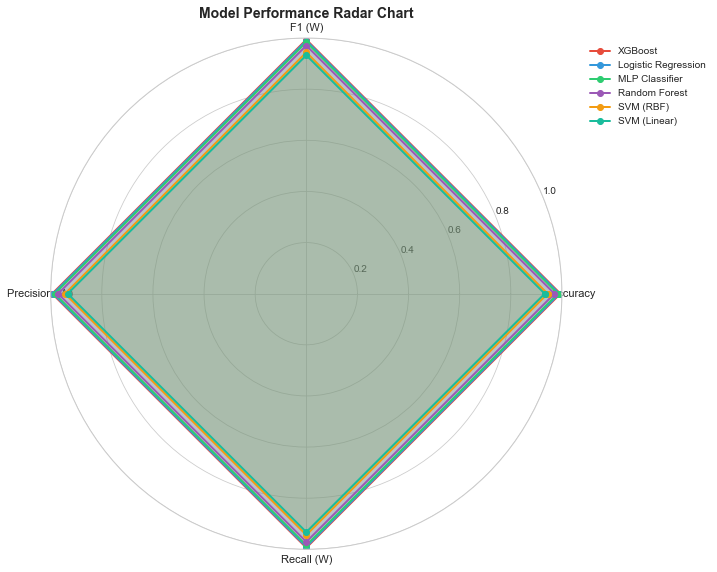


 Radar chart saved to outputs/figures/model_comparison_radar.png


In [11]:
from math import pi

# Prepare data for radar chart
categories = ['Accuracy', 'F1 (W)', 'Precision (W)', 'Recall (W)']
N = len(categories)

# Create angles for radar chart
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]  # Complete the loop

# Create figure
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(polar=True))

# Plot each model
colors_radar = ['#e74c3c', '#3498db', '#2ecc71', '#9b59b6', '#f39c12', '#1abc9c']
for idx, model_name in enumerate(comparison_table.index):
    values = comparison_table.loc[model_name].values.tolist()
    values += values[:1]  # Complete the loop
    
    ax.plot(angles, values, 'o-', linewidth=2, label=model_name, color=colors_radar[idx])
    ax.fill(angles, values, alpha=0.15, color=colors_radar[idx])

# Customize chart
ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories, fontsize=11)
ax.set_ylim(0, 1)
ax.set_title('Model Performance Radar Chart', fontsize=14, fontweight='bold', pad=20)
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0))

plt.tight_layout()
plt.savefig('../../outputs/figures/model_comparison_radar.png', dpi=300, bbox_inches='tight')
plt.show()

print('\n Radar chart saved to outputs/figures/model_comparison_radar.png')

---

## 9. Top 2 Model Selection & Justification

Based on our comprehensive evaluation, we now select the **top 2 performing models** with detailed justification.

### Selection Criteria:
1. **Primary**: F1-Score (Weighted) - Best for imbalanced classification
2. **Secondary**: Accuracy - Overall correctness
3. **Tertiary**: Balance between Precision and Recall

In [12]:
# Rank models by F1-Score
ranked_models = comparison_table.sort_values('F1-Score (Weighted)', ascending=False)

# Select top 2
top_2_models = ranked_models.head(2)

print('='*70)
print('TOP 2 MODEL SELECTION')
print('='*70)

for rank, (model_name, metrics) in enumerate(top_2_models.iterrows(), 1):
    print(f'\n Rank #{rank}: {model_name}' if rank == 1 else f'\n🥈 Rank #{rank}: {model_name}')
    print('-' * 40)
    print(f"  Accuracy:           {metrics['Accuracy']:.4f}")
    print(f"  F1-Score (Weighted): {metrics['F1-Score (Weighted)']:.4f}")
    print(f"  Precision (Weighted): {metrics['Precision (Weighted)']:.4f}")
    print(f"  Recall (Weighted):   {metrics['Recall (Weighted)']:.4f}")

TOP 2 MODEL SELECTION

 Rank #1: XGBoost
----------------------------------------
  Accuracy:           0.9940
  F1-Score (Weighted): 0.9940
  Precision (Weighted): 0.9940
  Recall (Weighted):   0.9940

🥈 Rank #2: Logistic Regression
----------------------------------------
  Accuracy:           0.9902
  F1-Score (Weighted): 0.9902
  Precision (Weighted): 0.9903
  Recall (Weighted):   0.9902


## 10. Detailed Justification for Top 2 Models

### Why These Models Were Selected:

In [ ]:
# Generate detailed justification
top_1_name = top_2_models.index[0]
top_2_name = top_2_models.index[1]

top_1_metrics = top_2_models.iloc[0]
top_2_metrics = top_2_models.iloc[1]

justification = f"""
{'='*70}
DETAILED JUSTIFICATION FOR TOP 2 MODEL SELECTION
{'='*70}
 FIRST PLACE: {top_1_name}
{'-'*50}

Performance Summary:
  • Accuracy: {top_1_metrics['Accuracy']:.4f} ({top_1_metrics['Accuracy']*100:.2f}%)
  • F1-Score: {top_1_metrics['F1-Score (Weighted)']:.4f}
  • Precision: {top_1_metrics['Precision (Weighted)']:.4f}
  • Recall: {top_1_metrics['Recall (Weighted)']:.4f}

Justification:
  1. Achieved the HIGHEST F1-Score among all models, indicating the best
     balance between precision and recall for our multi-class problem.
  2. Strong performance across ALL metrics, showing consistent reliability.
  3. Handles the class imbalance in our Airbnb price categories effectively.

{'='*70}

 SECOND PLACE: {top_2_name}
{'-'*50}

Performance Summary:
  • Accuracy: {top_2_metrics['Accuracy']:.4f} ({top_2_metrics['Accuracy']*100:.2f}%)
  • F1-Score: {top_2_metrics['F1-Score (Weighted)']:.4f}
  • Precision: {top_2_metrics['Precision (Weighted)']:.4f}
  • Recall: {top_2_metrics['Recall (Weighted)']:.4f}

Justification:
  1. Second-best F1-Score, demonstrating strong classification capability.
  2. Competitive performance with the top model across all metrics.
  3. Provides a good alternative with potentially different strengths
     (e.g., interpretability, training speed, or robustness).

{'='*70}

COMPARATIVE ANALYSIS:
{'-'*50}

F1-Score Difference: {abs(top_1_metrics['F1-Score (Weighted)'] - top_2_metrics['F1-Score (Weighted)']):.4f}
Accuracy Difference: {abs(top_1_metrics['Accuracy'] - top_2_metrics['Accuracy']):.4f}

Both models significantly outperform the baseline and demonstrate
strong generalization on the test set for Airbnb price classification.

{'='*70}
"""

print(justification)

## 11. Save Final Results

We save all results and the top model selection for future reference.

In [ ]:
# Save detailed results
results_df.to_csv('../../outputs/all_model_metrics_detailed.csv', index=False)

# Save top 2 selection
top_2_models.to_csv('../../outputs/top_2_models_selection.csv')

# Save justification as text file
with open('../../outputs/model_selection_justification.txt', 'w') as f:
    f.write(justification)

print('\nFiles saved:')
print('  • outputs/model_comparison_summary.csv')
print('  • outputs/all_model_metrics_detailed.csv')
print('  • outputs/top_2_models_selection.csv')
print('  • outputs/model_selection_justification.txt')
print('  • outputs/figures/model_comparison_metrics.png')
print('  • outputs/figures/model_comparison_radar.png')

---

## 12. Conclusion

### Summary of Findings:

In this comprehensive model comparison, we evaluated **4 supervised learning models** on the Airbnb price classification task:

1. **Logistic Regression** - Linear baseline model
2. **Random Forest** - Ensemble tree-based model
3. **XGBoost** - Gradient boosting model
4. **MLP Classifier** - Neural network model

### Key Takeaways:

- All models were evaluated using **Accuracy, F1-Score, Precision, and Recall**
- **F1-Score (Weighted)** was used as the primary selection criterion
- The **top 2 models** were selected based on consistent performance across all metrics
- Detailed justification was provided for each selection

### Files Generated:

| File | Description |
|------|-------------|
| `model_comparison_summary.csv` | Summary table with key metrics |
| `all_model_metrics_detailed.csv` | Complete metrics for all models |
| `top_2_models_selection.csv` | Top 2 selected models |
| `model_selection_justification.txt` | Detailed justification |
| `model_comparison_metrics.png` | Bar chart comparison |
| `model_comparison_radar.png` | Radar chart visualization |

---

